## MNIST Data

In [ ]:
using MLDatasets
using Plots
using Images
using StatsBase
using Random
using Printf
using ProgressMeter

In [ ]:
using Revise
using DenoisingDiffusion 

In [ ]:
includet("utilities.jl");

## Load

In [ ]:
data_directory="path\\to\\MNIST"
trainset = MNIST(Float32, :train, dir=data_directory)
testset = MNIST(Float32, :test, dir=data_directory)

display(trainset)
display(testset)

dataset MNIST:
  metadata    =>    Dict{String, Any} with 3 entries
  split       =>    :train
  features    =>    28×28×60000 Array{Float32, 3}
  targets     =>    60000-element Vector{Int64}

dataset MNIST:
  metadata    =>    Dict{String, Any} with 3 entries
  split       =>    :test
  features    =>    28×28×10000 Array{Float32, 3}
  targets     =>    10000-element Vector{Int64}

In [ ]:
for pair in trainset.metadata
    println(pair[1], " => ", pair[2])
end

n_observations => 60000
targets_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-labels-idx1-ubyte.gz
features_path => C:\Users\sinai\Documents\Projects\datasets\MNIST\train-images-idx3-ubyte.gz


## Data exploration

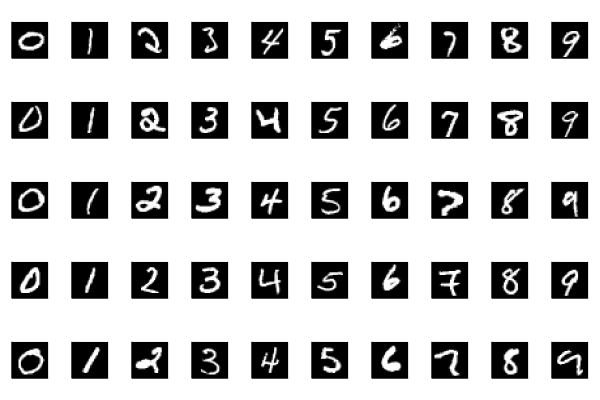

In [ ]:
nrows = 5
canvases = []
for label in 0:9
    idxs = (1:length(trainset))[trainset.targets .== label]
    for idx in rand(idxs, nrows)
        img = convert2image(trainset, trainset.features[:, :, idx])
        push!(canvases, plot(img))
    end
end
canvases = [canvases[nrows * j + i] for i in 1:nrows for j in 0:9]

plot(canvases..., layout=(nrows, 10), ticks=nothing)

In [ ]:
counts_labels = [count(x->x==label, trainset.targets) for label in 0:9];

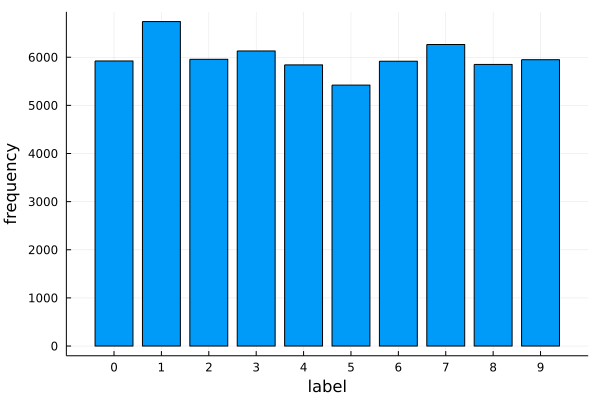

In [ ]:
bar(0:9, counts_labels, label="", xticks=0:9, xlabel="label", ylabel="frequency")

In [ ]:
mean_imgs = []
for label in 0:9
    idxs = trainset.targets .== label
    x_mean = mean(trainset.features[:, :, idxs], dims=3)
    mean_img = convert2image(trainset, x_mean)
    push!(mean_imgs, mean_img)
end

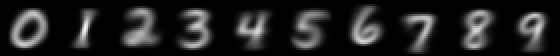

In [ ]:
imgs = cat(mean_imgs..., dims=2)
imgs[:, :, 1]

## Diffusion

In [ ]:
num_timesteps = 100
#βs = linear_beta_schedule(num_timesteps, 0.0001, 0.002) 
βs = cosine_beta_schedule(num_timesteps, 0.008)
diffusion = GaussianDiffusion(Vector{Float32}, βs, (28, 28, 1,), identity)

GaussianDiffusion{Vector{Float32}}(num_timesteps=100, data_shape=(28, 28, 1), denoise_fn=identity, buffers_size=5.156 KiB)

In [ ]:
idx = rand(1:length(trainset), 1)
X = trainset.features[:, :, idx]
X = reshape(X, size(X)..., 1) ;
X = normalize_neg_one_to_one(X);

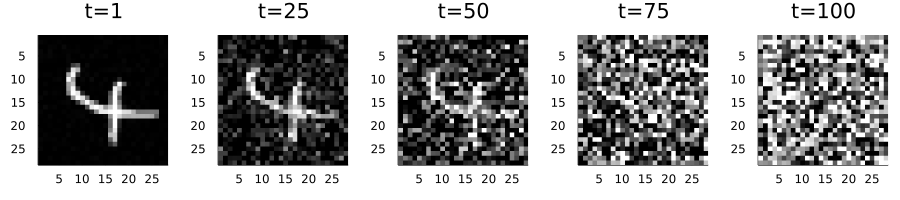

In [ ]:
canvases = []
for frac in [0.0, 0.25, 0.5, 0.75, 1]
    local p
    timestep = max(1, ceil(Int, frac * num_timesteps))
    Xt = q_sample(diffusion, X, timestep)
    clamp!(Xt, -one(Xt[1]), one(Xt[1]))
    img = convert2image(trainset, normalize_zero_to_one(Xt[:, :, 1, 1]))
    p = plot(img, title="t=$timestep")
    push!(canvases, p)
end

p = plot(canvases..., layout=(1, 5), link=:both, size=(900, 200))
savefig("../outputs/number_forward.png")
p

In [ ]:
XT = q_sample(diffusion, X, num_timesteps)
clamp!(XT, -one(XT[1]), one(XT[1]))
print(mean(XT), " ± ", std(XT)) # should be close to 0

In [ ]:
XT = q_sample(diffusion, X, num_timesteps)
anim_forward = @animate for t ∈ 1:1:(num_timesteps + 20)
    if t < num_timesteps
        Xt = q_sample(diffusion, X, t)
    else
        Xt = XT
        t = num_timesteps
    end
    clamp!(Xt, -one(Xt[1]), one(Xt[1]))
    img = convert2image(trainset, unnormalize_zero_to_one(Xt[:, :, 1, 1]))
    p = plot(img, title="t=$t")
end

-0.022933569 ± 0.712365

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_AqhcGW", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000111.png", "000112.png", "000113.png", "000114.png", "000115.png", "000116.png", "000117.png", "000118.png", "000119.png", "000120.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\number_forward.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\number_forward.gif")
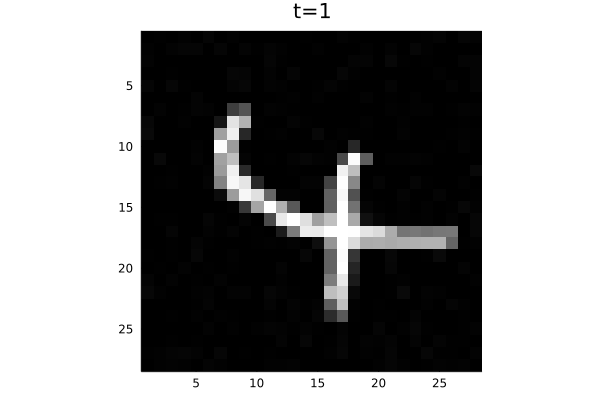

In [ ]:
gif(anim_forward, "../outputs/number_forward.gif", fps=15)

In [ ]:
amin_reverse = @animate for t ∈ (num_timesteps):-1:-20
    if t < 1
        t = 1
        Xt = X
    else
        Xt = q_sample(diffusion, X, t)
    end
    clamp!(Xt, -one(Xt[1]), one(Xt[1]))
    img = convert2image(trainset, unnormalize_zero_to_one(Xt[:, :, 1, 1]))
    p = plot(img, title="t=$t")
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_TyZ8CU", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000112.png", "000113.png", "000114.png", "000115.png", "000116.png", "000117.png", "000118.png", "000119.png", "000120.png", "000121.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\number_forward_reverse.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\number_forward_reverse.gif")
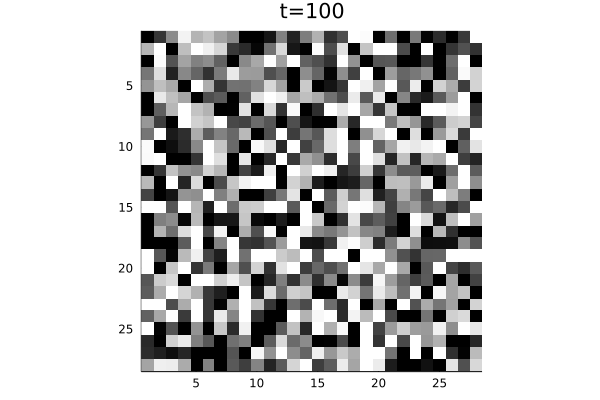

In [ ]:
gif(amin_reverse, "../outputs/number_forward_reverse.gif", fps=15)